<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

# Explore our Data & Preprocess

In [2]:
import os
# Create a path to the root folder and path to specific folders on my computer
data_path = "data/chest_xray/"

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'val/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

In [3]:
from PIL import Image

def detect_image_mode(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Check the number of channels
    num_channels = image.mode

    if num_channels == 'L':
        return "Black and White (Grayscale)"
    elif num_channels == 'RGB':
        return "Color (RGB)"
    else:
        return "Unknown"

# Example usage
image_path = r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg"
image_mode = detect_image_mode(image_path)
print(f"The image is in {image_mode} mode.")

The image is in Black and White (Grayscale) mode.


It seems that our images are actually greyscale meaning they have have 1 channel rather than 3 channels unlike RGB images. [reference pillow docs](https://pillow.readthedocs.io/en/stable/handbook/concepts.html)

In [4]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1341 normal images in the training set
There are 3875 pneumonia images in the training set
________________________________________________________________________________________
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 8 normal images in the validation set
There are 8 pneumonia images in the validation set


Lets preprocess the images by resizing to (256, 256, 1)

In [5]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(128, 32, train_data_dir, test_data_dir, val_data_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (128, 128, 1)


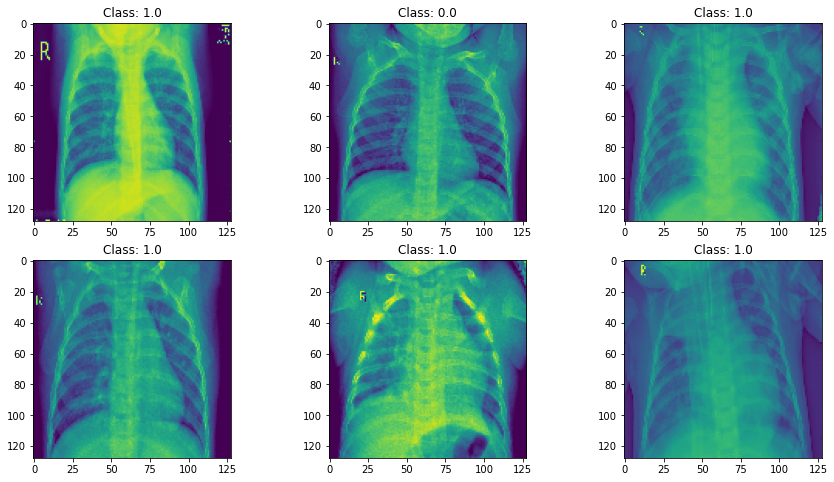

In [6]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

It seems images that arer very cloudy in the chest are Pneumonia while normal images are very clear. This means 1 is Pneumonia and 0 is Normal.

Image dimensions: (128, 128, 1)


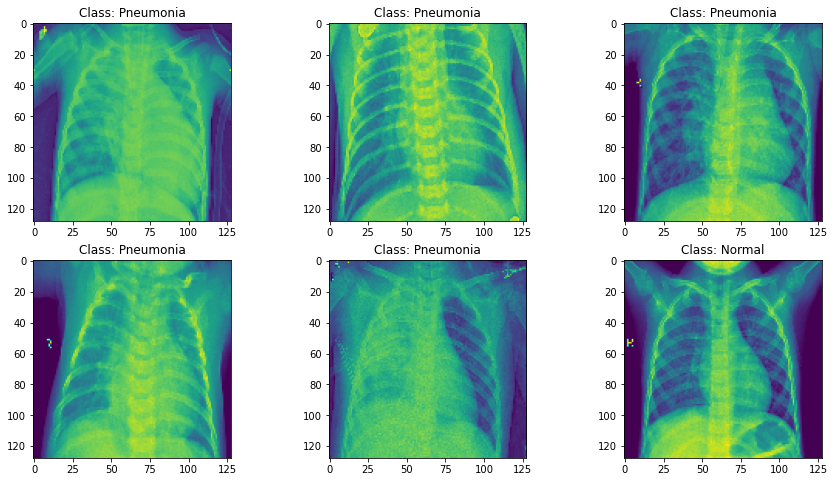

In [7]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [8]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
# Flatten layer to reshape the output
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(64, activation='relu'))

# Define the output 
model_mlp_base.add(Dense(1, activation='sigmoid'))


model_mlp_base.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,194,433
Trainable params: 4,194,433
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
163/163 [==============================] - 26s 159ms/step - loss: 1.0309 - precision: 0.7418 - recall: 0.9683 - accuracy: 0.7260 - val_loss: 0.6218 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 26s 157ms/step - loss: 0.3229 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.5588 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 3/15
163/163 [==============================] - 25s 155ms/step - loss: 0.2670 - precision: 0.8903 - recall: 0.9737 - accuracy: 0.8913 - val_loss: 0.6166 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 4/15
163/163 [==============================] - 25s 155ms/step - loss: 0.2489 - precision: 0.9571 - recall: 0.9559 - accuracy: 0.9354 - val_loss: 0.4359 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 25s 155ms/step - loss: 0.2527 - precis

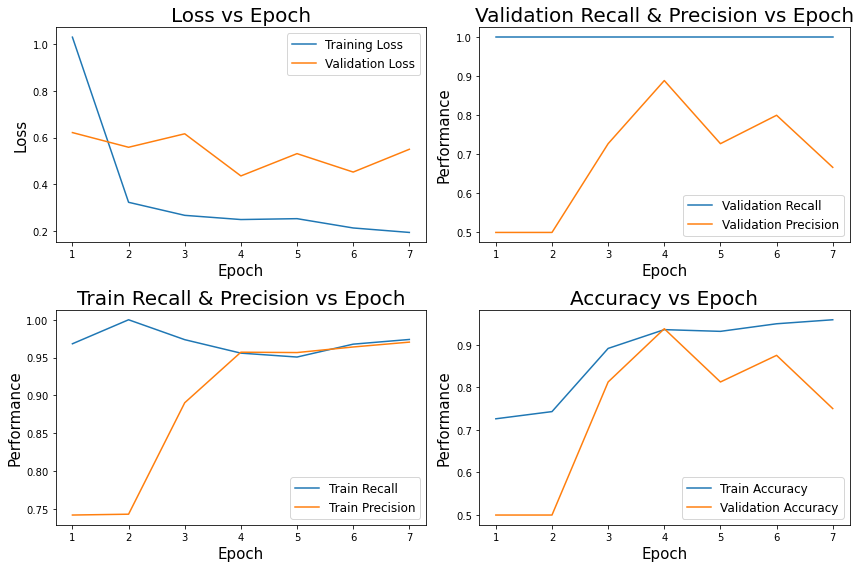

1/1 [==============================] - 0s 1ms/step - loss: 0.4359 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.220875,97.596025,96.387094,95.552146
1,Test,0.646407,74.658871,98.205125,78.044873
2,Validation,0.435938,88.888890,100.000000,93.750000


In [10]:
from functions import train_model, view_history, model_evaluate

mlp = {}

# Train the model
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=15)

# View History 
view_history(mlp, 'Version1')

# Evaluate model
model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

Our Train loss is very high at the beginning. Maybe the learning rate is too high so lets manually lower it. Adding on, it also seems that we do not really capture much feature extraction since the loss curves seem more like noise than signal. Our callbacks also has an implementation to reduce leanring rate if val loss does not improve;.

# MLP Version 2

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(128, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 8,388,865
Trainable params: 8,388,865
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
163/163 [==============================] - 27s 165ms/step - loss: 0.4140 - precision: 0.8701 - recall: 0.9333 - accuracy: 0.8468 - val_loss: 0.5309 - val_precision: 0.6667 - val_recall: 1.0000 - val_accuracy: 0.7500
Epoch 2/15
163/163 [==============================] - 26s 160ms/step - loss: 0.1811 - precision: 0.9444 - recall: 0.9693 - accuracy: 0.9348 - val_loss: 0.7381 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.1522 - precision: 0.9531 - recall: 0.9695 - accuracy: 0.9419
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
163/163 [==============================] - 26s 160ms/step - loss: 0.1522 - precision: 0.9531 - recall: 0.9695 - accuracy: 0.9419 - val_loss: 0.5445 - val_precision: 0.6667 - val_recall: 1.0000 - val_accuracy: 0.7500
Epoch 4/15
163/163 [==============================] - 26s 159ms/step - loss: 0.1296 - precision: 0.9623 - recall: 0.

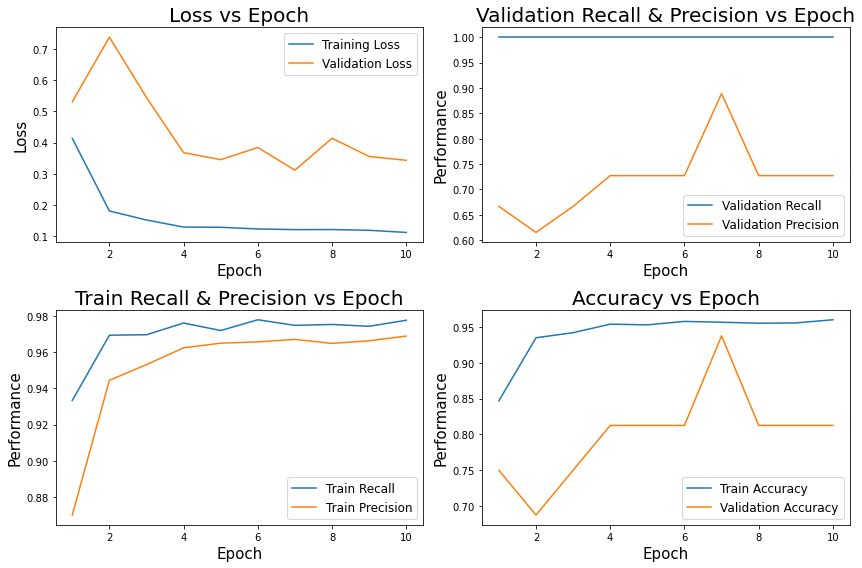

1/1 [==============================] - 0s 1ms/step - loss: 0.3119 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.117504,97.391528,97.316128,96.069783
1,Test,0.557574,73.846155,98.461539,77.243590
2,Validation,0.311929,88.888890,100.000000,93.750000


In [12]:
from functions import train_model, view_history, model_evaluate
mlp = {}

# Update our dictionary with Version 2
mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=15)

# View History
view_history(mlp, 'Version2')

# Evaluate model
model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

It seems that manually setting the learning rate did benefit us as our losses no are lower in general. Our metrics did not improve much. Our curves follow eachother at a consistent width apart by a difference of about .2. Lets make the model deeper to see if we can get more feature extraction.

# MLP Version 3

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(128, activation='relu'))
model_mlp_base_3.add(Dense(64, activation='relu'))


# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 8,397,057
Trainable params: 8,397,057
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
163/163 [==============================] - 26s 161ms/step - loss: 0.3131 - precision: 0.8935 - recall: 0.9312 - accuracy: 0.8664 - val_loss: 0.3184 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 2/15
163/163 [==============================] - 26s 160ms/step - loss: 0.1667 - precision: 0.9524 - recall: 0.9659 - accuracy: 0.9388 - val_loss: 0.2310 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 3/15
163/163 [==============================] - 26s 161ms/step - loss: 0.1494 - precision: 0.9570 - recall: 0.9641 - accuracy: 0.9411 - val_loss: 0.6014 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 4/15
163/163 [==============================] - 26s 163ms/step - loss: 0.1771 - precision: 0.9502 - recall: 0.9592 - accuracy: 0.9323 - val_loss: 0.2046 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 26s 159ms/step - loss: 0.1320 - precis

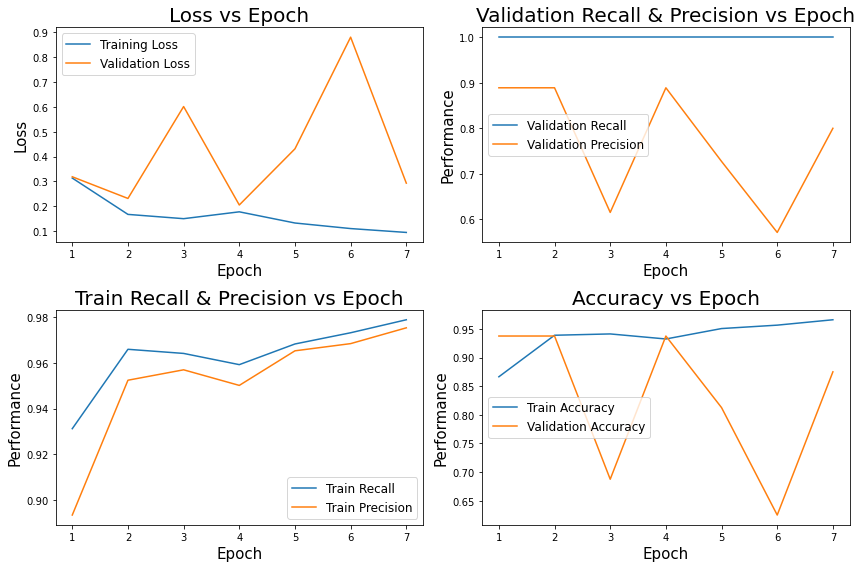

1/1 [==============================] - 0s 1000us/step - loss: 0.2046 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.129593,98.652655,94.477421,94.938648
1,Test,0.550937,76.938778,96.666664,79.807693
2,Validation,0.204600,88.888890,100.000000,93.750000


In [14]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version3')

# Evaluate model
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

It seems we had an ovefit occur. Lets add some regularization in between the hidden layers

# MLP Version 4

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(128, activation='relu'))
model_mlp_base_4.add(Dropout(rate=0.2, seed=42))
model_mlp_base_4.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 8,397,057
Trainable params: 8,397,057
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
163/163 [==============================] - 27s 165ms/step - loss: 0.3753 - precision: 0.8657 - recall: 0.9261 - accuracy: 0.8382 - val_loss: 0.4914 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 2/15
163/163 [==============================] - 26s 162ms/step - loss: 0.2113 - precision: 0.9312 - recall: 0.9541 - accuracy: 0.9135 - val_loss: 0.5272 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 3/15
163/163 [==============================] - 26s 159ms/step - loss: 0.1954 - precision: 0.9405 - recall: 0.9592 - accuracy: 0.9247 - val_loss: 0.4365 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 4/15
163/163 [==============================] - 26s 160ms/step - loss: 0.1623 - precision: 0.9543 - recall: 0.9592 - accuracy: 0.9356 - val_loss: 0.3728 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 5/15
163/163 [==============================] - 26s 159ms/step - loss: 0.1527 - precis

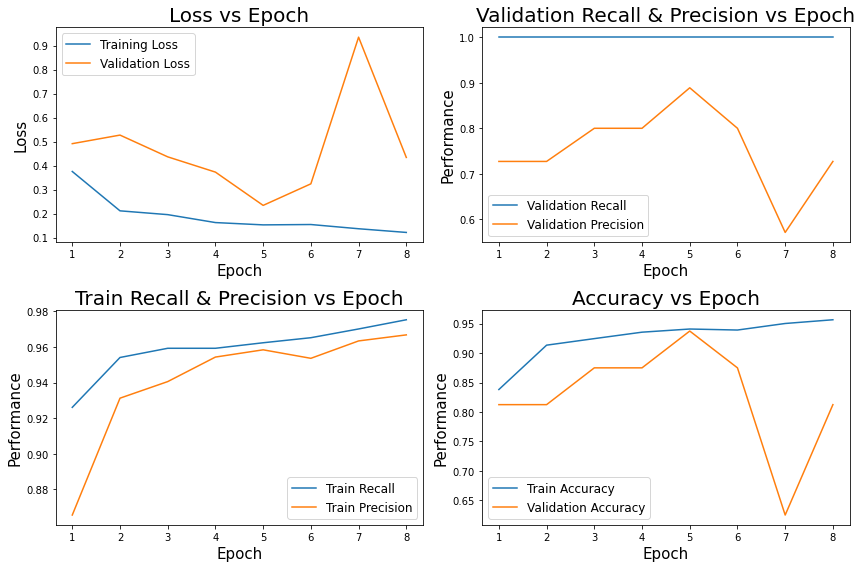

1/1 [==============================] - 0s 1ms/step - loss: 0.2340 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.147530,99.042147,93.393546,94.421011
1,Test,0.441072,78.601694,95.128202,80.769229
2,Validation,0.233970,88.888890,100.000000,93.750000


In [16]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=15)

# View history 
view_history(mlp, 'Version4')

# Evaluate model
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

It seems we did better here since our overall train loss is closer to our val loss. Since our curves dont look very smooth and are still decreasing with a gap between them we can add another layer to make the architecture deeper

# MLP Version 5

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(128, activation='relu'))
model_mlp_base_5.add(Dropout(rate=.4, seed=42))
model_mlp_base_5.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 8,397,057
Trainable params: 8,397,057
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
163/163 [==============================] - 26s 161ms/step - loss: 0.4488 - precision: 0.8535 - recall: 0.8929 - accuracy: 0.8064 - val_loss: 0.7202 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 2/15
163/163 [==============================] - 26s 158ms/step - loss: 0.2691 - precision: 0.9097 - recall: 0.9494 - accuracy: 0.8924 - val_loss: 0.5526 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 3/15
163/163 [==============================] - 26s 158ms/step - loss: 0.2501 - precision: 0.8950 - recall: 0.9507 - accuracy: 0.8806 - val_loss: 0.9717 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 4/15
163/163 [==============================] - 26s 158ms/step - loss: 0.2161 - precision: 0.9297 - recall: 0.9621 - accuracy: 0.9178 - val_loss: 0.4685 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 5/15
163/163 [==============================] - 26s 160ms/step - loss: 0.2104 - precis

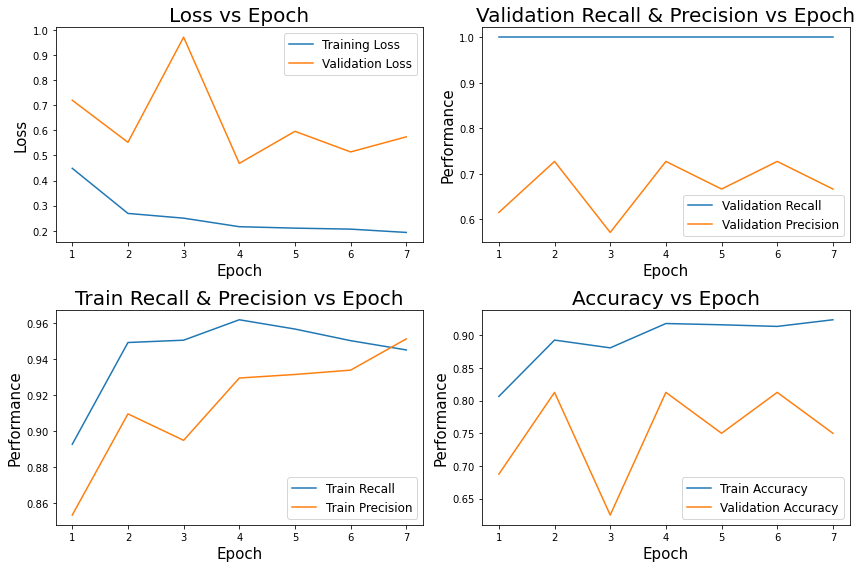

1/1 [==============================] - 0s 1ms/step - loss: 0.4685 - precision: 0.7273 - recall: 1.0000 - accuracy: 0.8125


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.145072,95.120120,98.090321,94.842792
1,Test,0.625459,71.828359,98.717946,75.000000
2,Validation,0.468472,72.727275,100.000000,81.250000


In [18]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version5')

# Evaluate model 
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

We perform about the same in metrics but our loss curves seem much more better showing that adding another layer showed benefit in leanring. Now the gap bwteen the curves is larger so the new layer needs regualization as well

# MLP Version 6

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_6.add(Dense(128, activation='relu'))
model_mlp_base_6.add(Dropout(rate=0.20, seed=42))
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dropout(rate=0.20, seed=42))

# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 8,397,057
Trainable params: 8,397,057
Non-trainable params: 0
____________________________________________

Epoch 1/15
163/163 [==============================] - 26s 161ms/step - loss: 0.3712 - precision: 0.8629 - recall: 0.9289 - accuracy: 0.8378 - val_loss: 0.7313 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 2/15
163/163 [==============================] - 26s 161ms/step - loss: 0.2739 - precision: 0.8960 - recall: 0.9450 - accuracy: 0.8777 - val_loss: 0.4527 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 3/15
163/163 [==============================] - 26s 160ms/step - loss: 0.2112 - precision: 0.9398 - recall: 0.9430 - accuracy: 0.9128 - val_loss: 0.3281 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 4/15
163/163 [==============================] - 26s 162ms/step - loss: 0.1832 - precision: 0.9529 - recall: 0.9551 - accuracy: 0.9316 - val_loss: 0.7692 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 5/15
163/163 [==============================] - 26s 160ms/step - loss: 0.1704 - precis

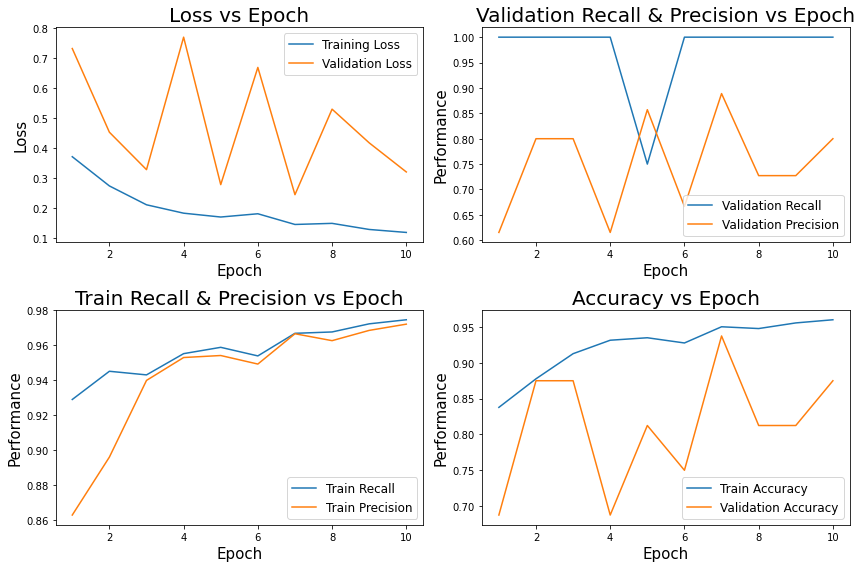

1/1 [==============================] - 0s 1ms/step - loss: 0.2448 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.104504,97.935718,96.722579,96.050614
1,Test,0.659342,74.274659,98.461539,77.724361
2,Validation,0.244826,88.888890,100.000000,93.750000


In [20]:
from functions import model_evaluate, view_history, train_model

# Train model
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version6')

# Evaluate model
model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

It seems we still do not overfit. No matter how many neurons we add we arent getting better metrics and we get very little loss improvement

# MLP version 7

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_7.add(Dense(256, activation='relu'))
model_mlp_base_7.add(Dropout(rate=0.20, seed=42))
model_mlp_base_7.add(Dense(128, activation='relu'))
model_mlp_base_7.add(Dropout(rate=0.20, seed=42))

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               16777472  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 16,810,497
Trainable params: 16,810,497
Non-trainable params: 0
__________________________________________

Epoch 1/15
163/163 [==============================] - 30s 182ms/step - loss: 0.4361 - precision: 0.8660 - recall: 0.9055 - accuracy: 0.8255 - val_loss: 0.5833 - val_precision: 0.6667 - val_recall: 1.0000 - val_accuracy: 0.7500
Epoch 2/15
163/163 [==============================] - 29s 178ms/step - loss: 0.2144 - precision: 0.9318 - recall: 0.9597 - accuracy: 0.9179 - val_loss: 0.3492 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 3/15
163/163 [==============================] - 29s 176ms/step - loss: 0.1891 - precision: 0.9430 - recall: 0.9600 - accuracy: 0.9271 - val_loss: 0.6855 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 4/15
163/163 [==============================] - 29s 178ms/step - loss: 0.1664 - precision: 0.9518 - recall: 0.9683 - accuracy: 0.9400 - val_loss: 0.2625 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 29s 179ms/step - loss: 0.1623 - precis

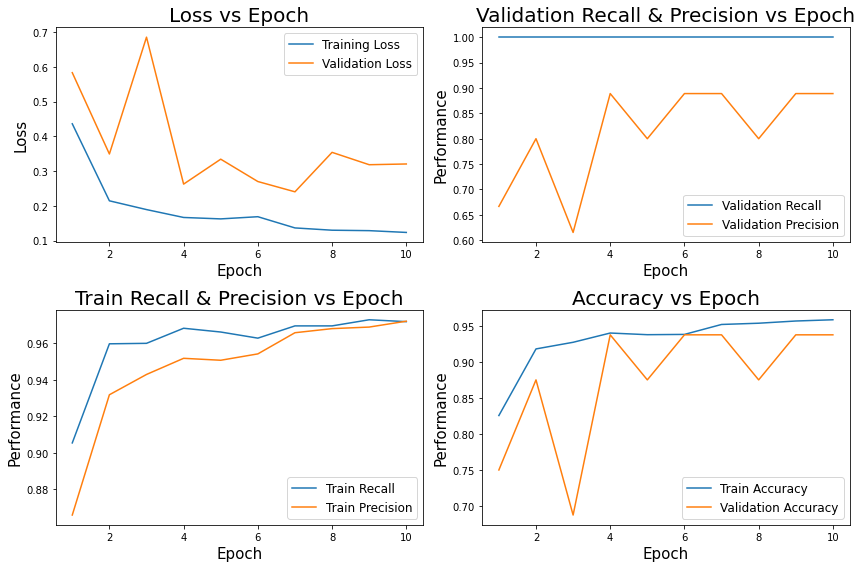

1/1 [==============================] - 0s 1ms/step - loss: 0.2403 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.119357,98.534507,95.432258,95.552146
1,Test,0.527865,76.047903,97.692305,79.326922
2,Validation,0.240301,88.888890,100.000000,93.750000


In [24]:
from functions import model_evaluate, train_model, view_history

# Train model
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=15)

# View History
view_history(mlp, 'Version7')

# Evaluate model
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

Now it seems that we did overfit. Lets return to the previous version 6

# MLP Version 8

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base_8 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_8.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_8.add(Dense(256, activation='relu'))
model_mlp_base_8.add(Dropout(rate=0.20, seed=42))
model_mlp_base_8.add(Dense(128, activation='relu'))
model_mlp_base_8.add(Dropout(rate=0.40, seed=42))

# Define output layer
model_mlp_base_8.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_8.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_8.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               16777472  
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 16,810,497
Trainable params: 16,810,497
Non-trainable params: 0
__________________________________________

Epoch 1/15
163/163 [==============================] - 29s 181ms/step - loss: 0.4801 - precision: 0.8603 - recall: 0.9008 - accuracy: 0.8175 - val_loss: 0.8606 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 2/15
163/163 [==============================] - 29s 176ms/step - loss: 0.2372 - precision: 0.9253 - recall: 0.9497 - accuracy: 0.9057 - val_loss: 0.4390 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 3/15
163/163 [==============================] - 29s 177ms/step - loss: 0.2089 - precision: 0.9390 - recall: 0.9582 - accuracy: 0.9227 - val_loss: 0.5159 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 4/15
163/163 [==============================] - 29s 176ms/step - loss: 0.1762 - precision: 0.9498 - recall: 0.9623 - accuracy: 0.9342 - val_loss: 0.2322 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/15
163/163 [==============================] - 29s 177ms/step - loss: 0.1799 - precis

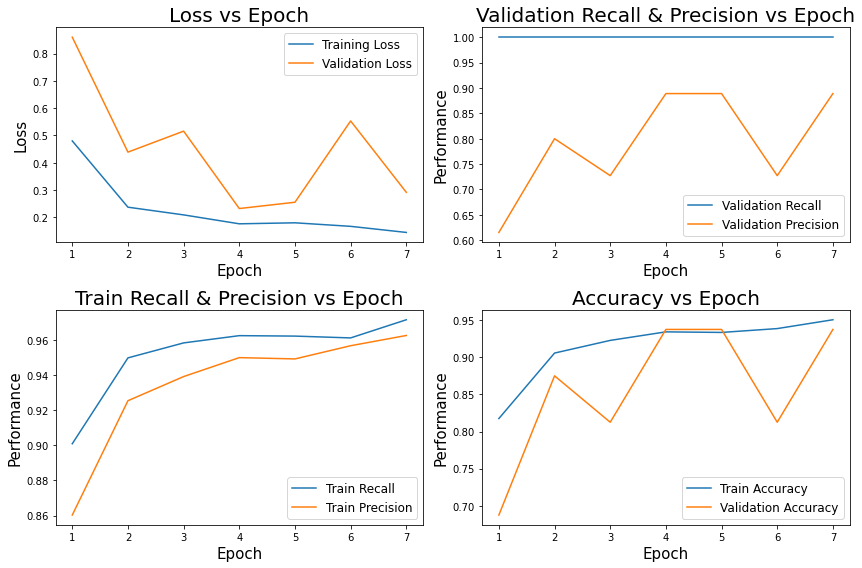

1/1 [==============================] - 0s 995us/step - loss: 0.2322 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.190463,99.093997,90.322578,92.197084
1,Test,0.379406,81.179136,91.794872,81.570512
2,Validation,0.232192,88.888890,100.000000,93.750000


In [26]:
from functions import model_evaluate, train_model, view_history

#Train model
mlp['Version8'] = train_model(model_mlp_base_8, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, "Version8")

# Evaluate model
model_evaluate(model_mlp_base_8, train_gen, test_gen, val_gen)

Its seems that Dense layers has reached its potential in feature extraction. Our loss metrics do not seem to be improving much. Our best performace was Version 8. Lets save the model and attempt dopin some data augmentation to see what occurs

In [27]:
# Save Version 6 
model_directory = 'models/'

model_mlp_base_8.save(model_directory + 'mlpv8.keras')

## Data Augmentation MLP

In [9]:
from tensorflow.keras.models import load_model

mlp = load_model("models/mlpv8.keras")

In [10]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Epoch 1/20
163/163 [==============================] - 42s 256ms/step - loss: 0.5994 - precision: 0.7659 - recall: 0.9515 - accuracy: 0.7479 - val_loss: 0.4276 - val_precision: 0.8750 - val_recall: 0.8750 - val_accuracy: 0.8750
Epoch 2/20
163/163 [==============================] - 40s 247ms/step - loss: 0.5772 - precision: 0.7615 - recall: 0.9665 - accuracy: 0.7502 - val_loss: 0.4715 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.5562 - precision: 0.7618 - recall: 0.9623 - accuracy: 0.7485
Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
163/163 [==============================] - 40s 248ms/step - loss: 0.5562 - precision: 0.7618 - recall: 0.9623 - accuracy: 0.7485 - val_loss: 0.4177 - val_precision: 0.8571 - val_recall: 0.7500 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 41s 251ms/step - loss: 0.5480 - precision: 0.7641 - recall: 0.9

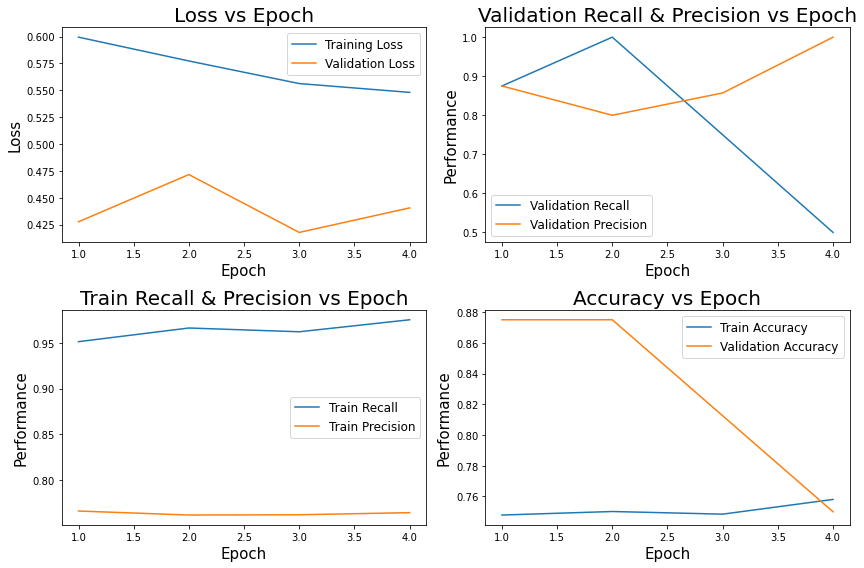

1/1 [==============================] - 0s 1ms/step - loss: 0.4276 - precision: 0.8750 - recall: 0.8750 - accuracy: 0.8750


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.538743,75.496948,98.993546,75.383437
1,Test,0.456198,81.651378,91.282052,81.730771
2,Validation,0.427631,87.500000,87.500000,87.500000


In [11]:
from functions import view_history, model_evaluate, train_model

# Train the model 
aug = {}

aug['Version1'] = train_model(mlp, train_gen_aug, val_gen_aug, 20)

# view history
view_history(aug, 'Version1')

# Evaluate model
model_evaluate(mlp, train_gen_aug, test_gen_aug, val_gen_aug)

# Convolutional Neural Network


Generally ConV networks do better for image classification because they can exploit the spatial structure images thus obtaining more information. 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
cnn_1 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_1.add(MaxPool2D(pool_size=(2,2), padding="valid"))

# Define the Dense Layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_1.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16257152  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 16,257,601
Trainable params: 16,257,601
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
163/163 [==============================] - 36s 222ms/step - loss: 0.3229 - precision: 0.8741 - recall: 0.9572 - accuracy: 0.8658 - val_loss: 0.8149 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 2/30
163/163 [==============================] - 36s 221ms/step - loss: 0.1438 - precision: 0.9603 - recall: 0.9726 - accuracy: 0.9498 - val_loss: 0.4796 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 3/30
163/163 [==============================] - 36s 223ms/step - loss: 0.1074 - precision: 0.9728 - recall: 0.9778 - accuracy: 0.9632 - val_loss: 0.7623 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 4/30
163/163 [==============================] - 36s 222ms/step - loss: 0.1021 - precision: 0.9740 - recall: 0.9760 - accuracy: 0.9628 - val_loss: 0.2387 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/30
163/163 [==============================] - 36s 219ms/step - loss: 0.0843 - precis

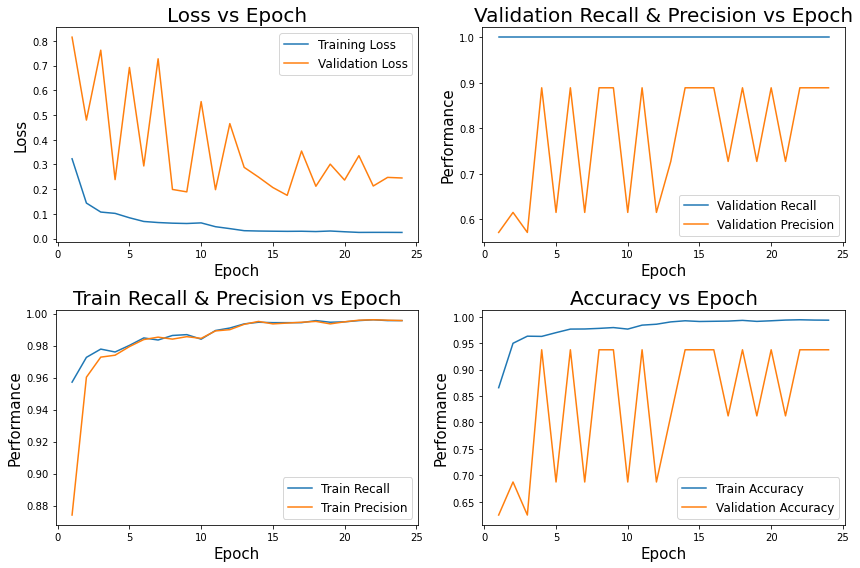

1/1 [==============================] - 0s 1ms/step - loss: 0.1751 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.030413,99.688554,99.122578,99.118096
1,Test,0.817392,72.744364,99.230766,76.282054
2,Validation,0.175079,88.888890,100.000000,93.750000


In [12]:
from functions import train_model, model_evaluate, view_history

cnn = {}

# Train model
cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 30)

# View history 
view_history(cnn, 'Version1')

# Evalaute model
model_evaluate(cnn_1, train_gen, test_gen, val_gen)

It seems that we generally decrease over time for both loss curves. Lets make our network deeper

# CNN Version 2

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
cnn_2 = Sequential()

# Define the layers
# Define our Conv layer
cnn_2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_2.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_2.add(Flatten())

# Define our Dense Layers
cnn_2.add(Dense(128, activation='relu'))
cnn_2.add(Dense(64, activation='relu'))

# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16257152  
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 16,265,793
Trainable params: 16,265,793
Non-trainable params: 0
__________________________________________

Epoch 1/30
163/163 [==============================] - 37s 228ms/step - loss: 0.3100 - precision: 0.8724 - recall: 0.9717 - accuracy: 0.8733 - val_loss: 0.4769 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 2/30
163/163 [==============================] - 36s 223ms/step - loss: 0.1391 - precision: 0.9647 - recall: 0.9724 - accuracy: 0.9530 - val_loss: 0.3175 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 3/30
163/163 [==============================] - 36s 221ms/step - loss: 0.0986 - precision: 0.9765 - recall: 0.9778 - accuracy: 0.9661 - val_loss: 0.2438 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 4/30
163/163 [==============================] - 36s 224ms/step - loss: 0.0810 - precision: 0.9781 - recall: 0.9804 - accuracy: 0.9691 - val_loss: 0.1808 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/30
163/163 [==============================] - 36s 222ms/step - loss: 0.0702 - precis

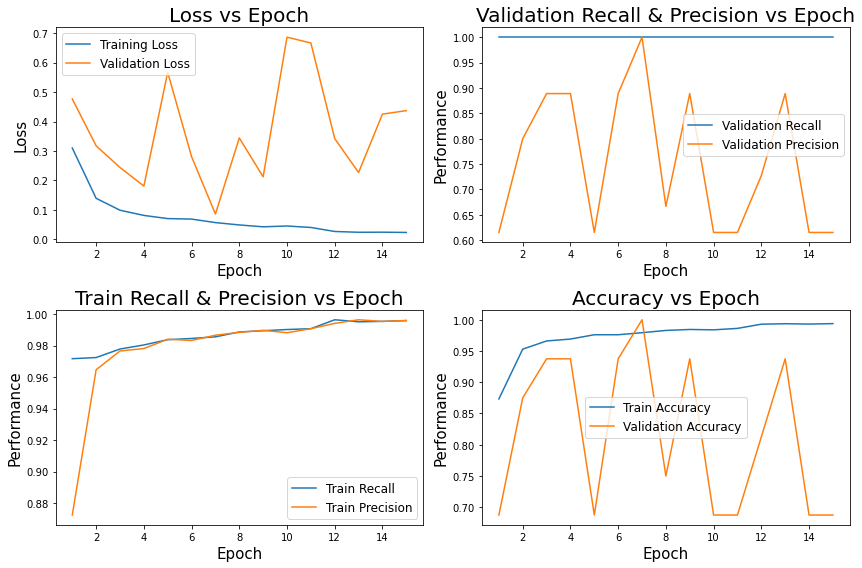

1/1 [==============================] - 0s 2ms/step - loss: 0.0857 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.090030,99.918872,95.354837,96.491563
1,Test,0.435729,80.338264,97.435898,83.493590
2,Validation,0.085741,100.000000,100.000000,100.000000


In [14]:
from functions import train_model, model_evaluate, view_history
cnn = {}
# Train the model
cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 30)

# View History 
view_history(cnn, "Version2")

# Evalauate Model
model_evaluate(cnn_2, train_gen, test_gen, val_gen)

It seems we did overfit as the trend started going upwards from epoch 7. We can add some regularization and see if it will fix this overfit

# CNN Version 3

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
cnn_3 = Sequential()

# Define the layers
# Define our Conv layer
cnn_3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_3.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_3.add(Flatten())

# Define our Dense Layers
cnn_3.add(Dense(128, activation='relu'))
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dropout(rate=0.2, seed=42))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16257152  
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Epoch 1/30
163/163 [==============================] - 36s 223ms/step - loss: 0.3148 - precision: 0.8762 - recall: 0.9500 - accuracy: 0.8629 - val_loss: 0.7522 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 2/30
163/163 [==============================] - 36s 223ms/step - loss: 0.1416 - precision: 0.9611 - recall: 0.9693 - accuracy: 0.9480 - val_loss: 0.7002 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 3/30
163/163 [==============================] - 36s 220ms/step - loss: 0.1110 - precision: 0.9717 - recall: 0.9734 - accuracy: 0.9592 - val_loss: 0.3291 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 4/30
163/163 [==============================] - 36s 220ms/step - loss: 0.0967 - precision: 0.9766 - recall: 0.9788 - accuracy: 0.9668 - val_loss: 0.5033 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 5/30
163/163 [==============================] - 36s 220ms/step - loss: 0.0842 - precis

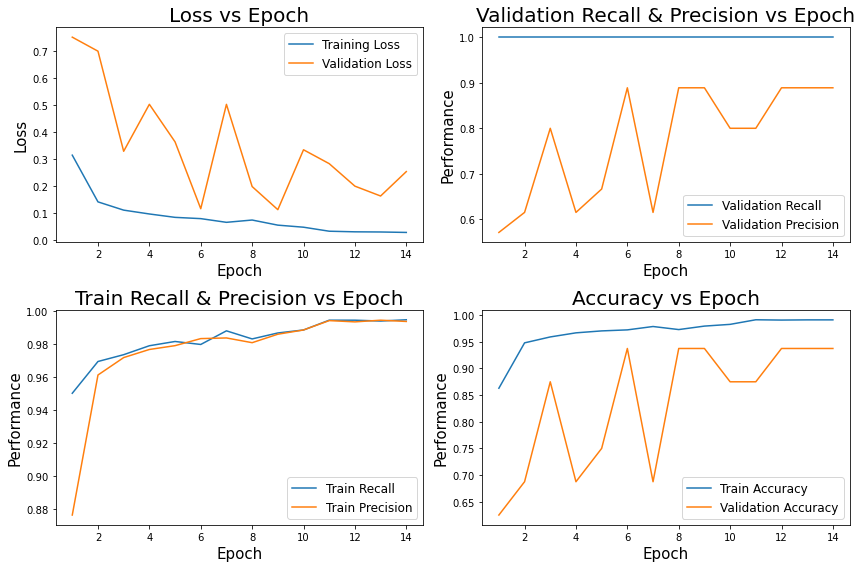

1/1 [==============================] - 0s 1000us/step - loss: 0.1162 - precision: 0.8889 - recall: 1.0000 - accuracy: 0.9375


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.086796,99.757153,95.406449,96.414876
1,Test,0.441800,80.761099,97.948718,84.134614
2,Validation,0.116199,88.888890,100.000000,93.750000


In [16]:
from functions import train_model, view_history, model_evaluate

# Train model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version3')

# Evaluate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

It seems that we can increase learning rate somewhere between the current setting to the default. Something in between such as 0.0005. Adding on, we are still overfitting slighlty so we can increase our Dropout

# CNN Version 4


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (128, 128, 1)

# Define the basic model 
cnn_4 = Sequential()

# Define the layers
# Define our Conv layer
cnn_4.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape))
cnn_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_4.add(Flatten())

# Define our Dense Layers
cnn_4.add(Dense(128, activation='relu'))
cnn_4.add(Dense(64, activation='relu'))
cnn_3.add(Dropout(rate=0.4, seed=42))

# Define output layer
cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_4.compile(optimizer=Adam(learning_rate=0.0005), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_4.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16777344  
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 16,785,985
Trainable params: 16,785,985
Non-trainable params: 0
__________________________________________

Epoch 1/30
163/163 [==============================] - 37s 225ms/step - loss: 0.2384 - precision: 0.9194 - recall: 0.9547 - accuracy: 0.9041 - val_loss: 0.2582 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 2/30
163/163 [==============================] - 36s 221ms/step - loss: 0.1039 - precision: 0.9712 - recall: 0.9747 - accuracy: 0.9597 - val_loss: 0.4271 - val_precision: 0.6154 - val_recall: 1.0000 - val_accuracy: 0.6875
Epoch 3/30
163/163 [==============================] - 36s 223ms/step - loss: 0.0638 - precision: 0.9850 - recall: 0.9853 - accuracy: 0.9780 - val_loss: 0.2855 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 4/30
163/163 [==============================] - 36s 223ms/step - loss: 0.0590 - precision: 0.9851 - recall: 0.9868 - accuracy: 0.9791 - val_loss: 0.0669 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 5/30
163/163 [==============================] - 36s 221ms/step - loss: 0.0352 - precis

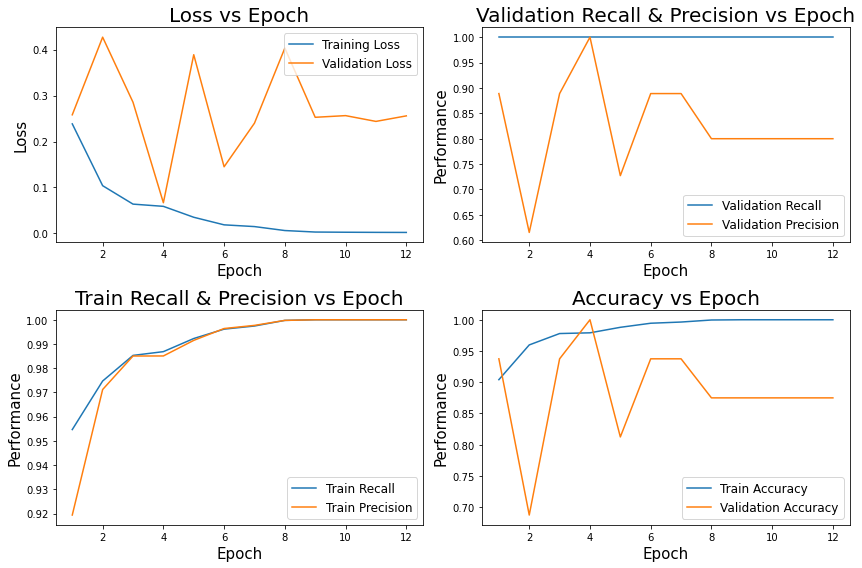

1/1 [==============================] - 0s 1000us/step - loss: 0.0669 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.098194,100.000000,94.787097,96.127301
1,Test,0.427362,81.545067,97.435898,84.615386
2,Validation,0.066851,100.000000,100.000000,100.000000


In [18]:
from functions import view_history, model_evaluate, train_model
# Train model

cnn['Version4'] = train_model(cnn_4, train_gen, val_gen, 30)

# Display history 
view_history(cnn, 'Version4')

# Evaluate Model
model_evaluate(cnn_4, train_gen, test_gen, val_gen)

It seems that we are still overfitting. Lets add l2 regulariation on the layer

# CNN Version 5 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_5 = Sequential()

# Define the layers
# Define our Conv layer
cnn_5.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='valid', input_shape=input_shape))
cnn_5.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

# Flatten the input layer for the Dense layers
cnn_5.add(Flatten())

# Define our Dense Layers
cnn_5.add(Dense(128, activation='relu'))
cnn_5.add(Dense(64, activation='relu', kernel_regularizer='l2'))
cnn_5.add(Dropout(rate=0.4, seed=42))

# Define output layer
cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_5.compile(optimizer=Adam(learning_rate=0.0005), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_5.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               33554560  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 33,555,905
Trainable params: 33,555,905
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
66/66 [==============================] - 59s 890ms/step - loss: 0.5397 - precision: 0.7786 - recall: 0.9882 - accuracy: 0.7385 - val_loss: 0.4761 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 59s 892ms/step - loss: 0.4429 - precision: 0.7616 - recall: 0.9994 - accuracy: 0.7674 - val_loss: 0.3948 - val_precision: 0.8314 - val_recall: 0.9974 - val_accuracy: 0.8478
Epoch 3/25
66/66 [==============================] - 58s 883ms/step - loss: 0.3760 - precision: 0.8301 - recall: 0.9926 - accuracy: 0.8438 - val_loss: 0.3371 - val_precision: 0.8766 - val_recall: 0.9884 - val_accuracy: 0.8880
Epoch 4/25
66/66 [==============================] - 58s 880ms/step - loss: 0.3304 - precision: 0.8664 - recall: 0.9874 - accuracy: 0.8777 - val_loss: 0.2997 - val_precision: 0.8950 - val_recall: 0.9884 - val_accuracy: 0.9053
Epoch 5/25
66/66 [==============================] - 58s 885ms/step - loss: 0.2984 - precision: 0.893

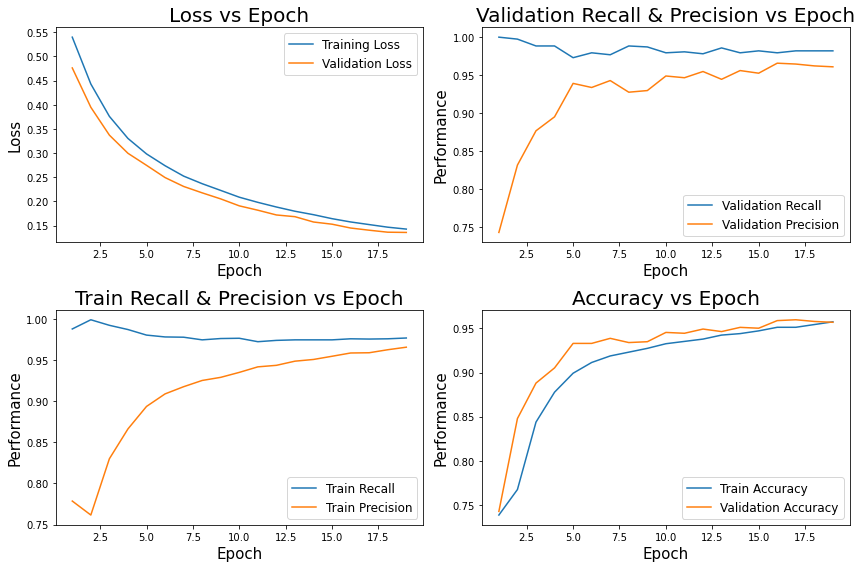

17/17 [==============================] - 7s 432ms/step - loss: 0.1451 - precision: 0.9657 - recall: 0.9794 - accuracy: 0.9589


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.154003,96.488988,97.296429,95.366609
1,Test,0.320984,82.127661,98.974359,85.897434
2,Validation,0.145143,96.569252,97.938144,95.885170


In [13]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version5'] = train_model(cnn_5, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version5')

# Evaluate Model
model_evaluate(cnn_5, train_gen, test_gen, val_gen)

This is good progress as our test loss is now .2 less than what it was. Adding more regularization is helping. Lets keep the same architecture but increase dropout 

# CNN Version 6

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_6 = Sequential()

# Define the layers
# Define our Conv layer
cnn_6.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_6.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_6.add(Flatten())

# Define our Dense Layers
cnn_6.add(Dense(64, activation='relu'))

# Define output layer
cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_6.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_6.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16777280  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 16,778,561
Trainable params: 16,778,561
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
66/66 [==============================] - 56s 847ms/step - loss: 0.5354 - precision: 0.7774 - recall: 0.9959 - accuracy: 0.7421 - val_loss: 0.4815 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 55s 838ms/step - loss: 0.4465 - precision: 0.7649 - recall: 0.9977 - accuracy: 0.7707 - val_loss: 0.3998 - val_precision: 0.7971 - val_recall: 0.9974 - val_accuracy: 0.8096
Epoch 3/25
66/66 [==============================] - 55s 836ms/step - loss: 0.3822 - precision: 0.8176 - recall: 0.9942 - accuracy: 0.8311 - val_loss: 0.3478 - val_precision: 0.8395 - val_recall: 0.9974 - val_accuracy: 0.8565
Epoch 4/25
66/66 [==============================] - 56s 845ms/step - loss: 0.3395 - precision: 0.8639 - recall: 0.9871 - accuracy: 0.8751 - val_loss: 0.3080 - val_precision: 0.8910 - val_recall: 0.9897 - val_accuracy: 0.9024
Epoch 5/25
66/66 [==============================] - 55s 838ms/step - loss: 0.3051 - precision: 0.885

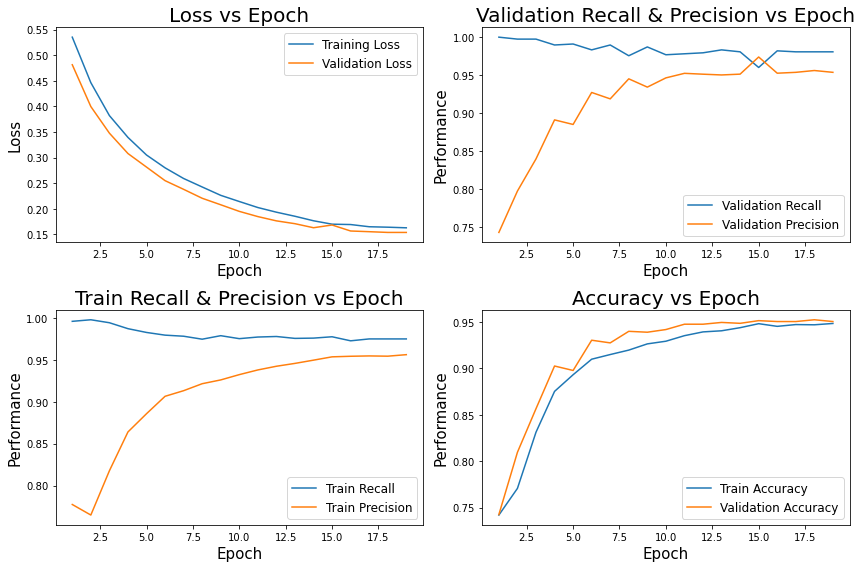

17/17 [==============================] - 7s 421ms/step - loss: 0.1566 - precision: 0.9525 - recall: 0.9820 - accuracy: 0.9502


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.165264,95.054775,97.747022,94.554573
1,Test,0.346983,79.835391,99.487180,83.974361
2,Validation,0.156588,95.249999,98.195875,95.023924


In [15]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version6'] = train_model(cnn_6, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version6')

# Evaluate Model
model_evaluate(cnn_6, train_gen, test_gen, val_gen)

We can see how we start to overfit with every epoch very slowly. To confirm lets just increase the information recieved by the dense layers by increase our filters since it is a little difficult to tell.

# CNN version 7

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_7 = Sequential()

# Define the layers
# Define our Conv layer
cnn_7.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_7.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_7.add(Flatten())

# Define our Dense Layers 
cnn_7.add(Dense(128, activation='relu'))
cnn_7.add(Dense(32, activation='relu'))

# Define output layer
cnn_7.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_7.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_7.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33554560  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 33,559,937
Trainable params: 33,559,937
Non-trainable params: 0
____________________________________________

Epoch 1/25
66/66 [==============================] - 60s 916ms/step - loss: 0.5550 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.5135 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 59s 897ms/step - loss: 0.4796 - precision: 0.7449 - recall: 1.0000 - accuracy: 0.7459 - val_loss: 0.4320 - val_precision: 0.7591 - val_recall: 0.9987 - val_accuracy: 0.7636
Epoch 3/25
66/66 [==============================] - 59s 889ms/step - loss: 0.4118 - precision: 0.7913 - recall: 0.9971 - accuracy: 0.8027 - val_loss: 0.3760 - val_precision: 0.7922 - val_recall: 0.9974 - val_accuracy: 0.8038
Epoch 4/25
66/66 [==============================] - 59s 890ms/step - loss: 0.3617 - precision: 0.8445 - recall: 0.9897 - accuracy: 0.8572 - val_loss: 0.3291 - val_precision: 0.8632 - val_recall: 0.9923 - val_accuracy: 0.8775
Epoch 5/25
66/66 [==============================] - 59s 892ms/step - loss: 0.3248 - precision: 0.872

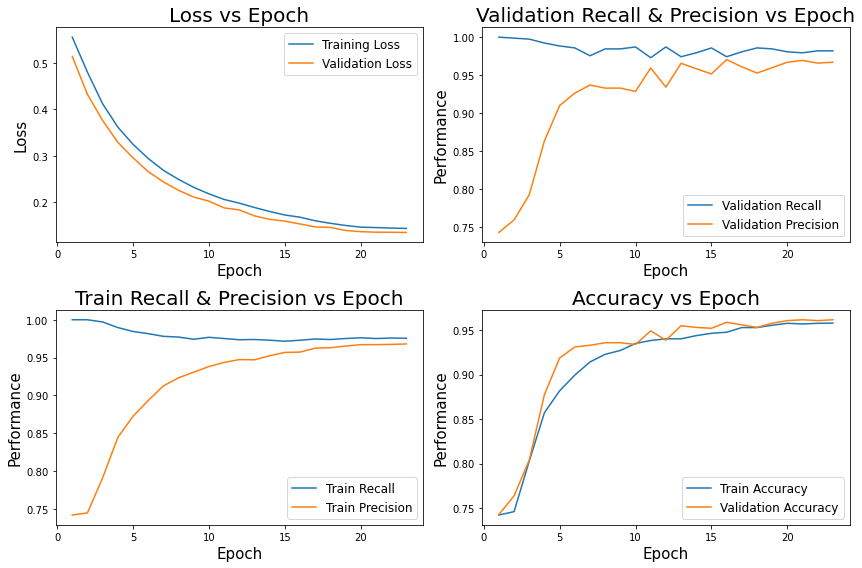

17/17 [==============================] - 7s 426ms/step - loss: 0.1371 - precision: 0.9670 - recall: 0.9807 - accuracy: 0.9608


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.145901,96.775222,97.553909,95.772630
1,Test,0.320008,81.512606,99.487180,85.576922
2,Validation,0.137140,96.696317,98.067009,96.076554


In [10]:
from functions import model_evaluate, train_model, view_history
cnn = {}

# Train model
cnn['Version7'] = train_model(cnn_7, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version7')

# Evaluate Model
model_evaluate(cnn_7, train_gen, test_gen, val_gen)

It seems that version 5 does better. We can attempt to generalize better by maybe adding more dense neurons to the first layer

# CNN Version 8

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_8 = Sequential()

# Define the layers
# Define our Conv layer
cnn_8.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
cnn_8.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_8.add(Flatten())

# Define our Dense Layers
cnn_8.add(Dense(128, activation='relu'))
cnn_8.add(Dense(32, activation='relu'))


# Define output layer
cnn_8.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_8.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_8.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               33554560  
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 1/25
66/66 [==============================] - 102s 2s/step - loss: 0.5608 - precision: 0.7776 - recall: 0.9961 - accuracy: 0.7421 - val_loss: 0.5218 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 101s 2s/step - loss: 0.4953 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.4554 - val_precision: 0.7454 - val_recall: 1.0000 - val_accuracy: 0.7464
Epoch 3/25
66/66 [==============================] - 102s 2s/step - loss: 0.4344 - precision: 0.7594 - recall: 0.9997 - accuracy: 0.7647 - val_loss: 0.3999 - val_precision: 0.7996 - val_recall: 0.9974 - val_accuracy: 0.8124
Epoch 4/25
66/66 [==============================] - 101s 2s/step - loss: 0.3907 - precision: 0.8170 - recall: 0.9942 - accuracy: 0.8304 - val_loss: 0.3600 - val_precision: 0.8190 - val_recall: 0.9974 - val_accuracy: 0.8344
Epoch 5/25
66/66 [==============================] - 102s 2s/step - loss: 0.3558 - precision: 0.8482 - recall

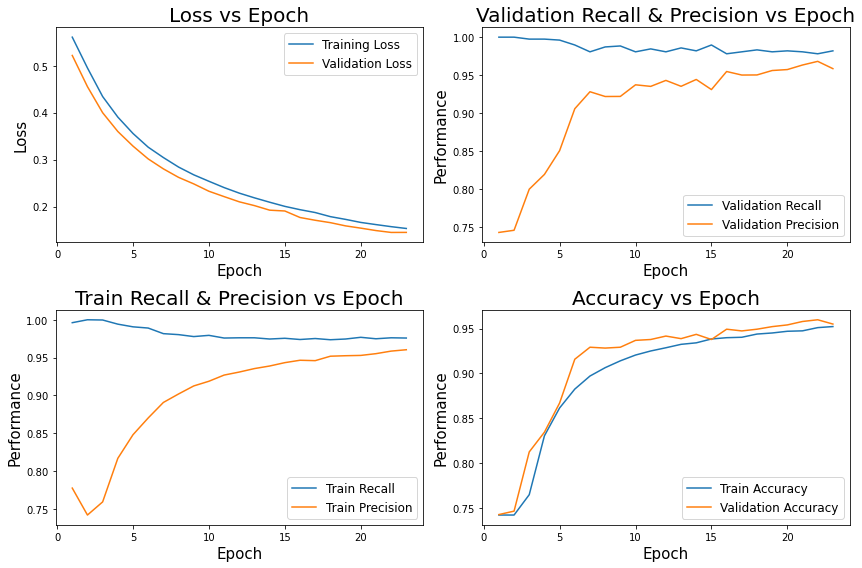

17/17 [==============================] - 8s 459ms/step - loss: 0.1543 - precision: 0.9573 - recall: 0.9820 - accuracy: 0.9541


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.163518,95.559055,97.650468,94.888943
1,Test,0.330712,81.171548,99.487180,85.256410
2,Validation,0.154301,95.728642,98.195875,95.406699


In [12]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version 8'] = train_model(cnn_8, train_gen, val_gen, 25)

# View History 
view_history(cnn, 'Version 8')

# Evaluate model
model_evaluate(cnn_8, train_gen, test_gen, val_gen)

I would say adding more neurons actually did not give any performance gain at all. This is where we should do data augmentation using Version 5

In [25]:
cnn_5.save("models/cnn5.keras")

In [26]:
cnn_5.save("models/cnn5control.keras")

# Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data generators. 

In [34]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [28]:
from tensorflow.keras.models import load_model

model_1 = load_model("models/cnn5.keras")

Epoch 1/15
123/123 [==============================] - 126s 1s/step - loss: 0.6548 - precision: 0.6930 - recall: 0.9430 - accuracy: 0.6718 - val_loss: 0.4647 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 2/15
123/123 [==============================] - 121s 986ms/step - loss: 0.6209 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4554 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 3/15
123/123 [==============================] - 126s 1s/step - loss: 0.6200 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4468 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 4/15
123/123 [==============================] - 123s 999ms/step - loss: 0.6188 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4417 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 5/15
123/123 [==============================] - 121s 982ms/step - loss: 0.6186 - precisi

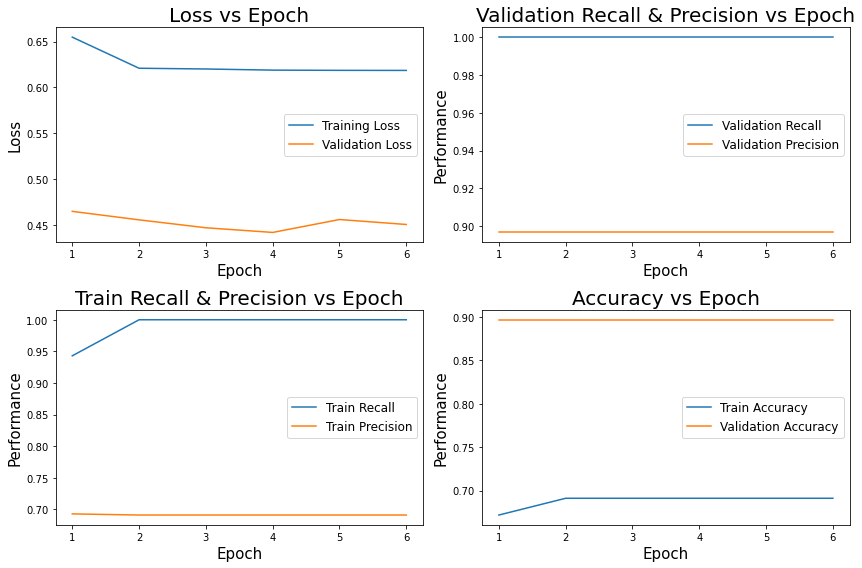

41/41 [==============================] - 14s 337ms/step - loss: 0.4468 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618868,69.115406,100.0,69.115406
1,Test,0.674243,62.500000,100.0,62.500000
2,Validation,0.446760,89.676428,100.0,89.676428


In [29]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model1 = {}

# Train the model
cnn_aug_model1['Version1'] = train_model(model_1, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model1, 'Version1')

# Evaluate model
model_evaluate(model_1, train_gen_aug, test_gen_aug, val_gen_aug)

In [30]:
# Evaluate model
model_evaluate(model_1, train_gen, test_gen, val_gen)

41/41 [==============================] - 14s 329ms/step - loss: 0.4468 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618868,69.115406,100.0,69.115406
1,Test,0.674243,62.500000,100.0,62.500000
2,Validation,0.446760,89.676428,100.0,89.676428


In [33]:
# Save our model from augmented training
model_1.save("models/cnn5_aug.keras")

Our losses in our test are much better. Every loss decreases suggetsing that the model is learning better. Unfortunartly our metrics did not improve by much however this model version is much more reliable then the pervious non augmented version

# Transfer Learning

Another method to use here would be to use an already pre trained network and see the results with our network

In [35]:
# Initialize Base
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Load in the pretrained CNN
cnn_base_vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

# Make configuration
model_pre = Sequential()
model_pre.add(cnn_base_vgg)
model_pre.add(Flatten())

# Define the same dense layers with our best cnn version that I made 
# Define our Dense Layers
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
model_pre.add(Dense(1, activation='sigmoid'))

# Define the pretrained model as an exclusion from changing its weights
cnn_base_vgg.trainable = False

model_pre.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_pre.summary())

80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_______________________________________________________

Epoch 1/15
123/123 [==============================] - 422s 3s/step - loss: 6.7044 - precision: 0.8949 - recall: 0.9209 - accuracy: 0.8208 - val_loss: 2.5334 - val_precision: 0.9942 - val_recall: 0.8840 - val_accuracy: 0.8914
Epoch 2/15
123/123 [==============================] - 415s 3s/step - loss: 1.3153 - precision: 0.9202 - recall: 0.9033 - accuracy: 0.8790 - val_loss: 0.4619 - val_precision: 0.9605 - val_recall: 0.9811 - val_accuracy: 0.9468
Epoch 3/15
123/123 [==============================] - 416s 3s/step - loss: 0.4165 - precision: 0.9413 - recall: 0.9139 - accuracy: 0.9011 - val_loss: 0.2893 - val_precision: 0.9981 - val_recall: 0.8918 - val_accuracy: 0.9014
Epoch 4/15
123/123 [==============================] - 416s 3s/step - loss: 0.2781 - precision: 0.9429 - recall: 0.9235 - accuracy: 0.9085 - val_loss: 0.1307 - val_precision: 0.9895 - val_recall: 0.9708 - val_accuracy: 0.9646
Epoch 5/15
123/123 [==============================] - 418s 3s/step - loss: 0.2589 - precision: 0.942

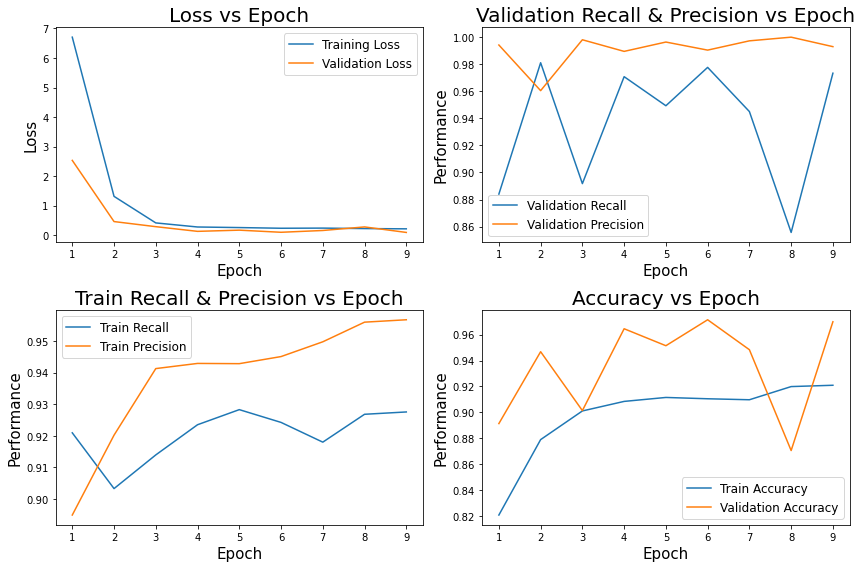

41/41 [==============================] - 101s 2s/step - loss: 0.0994 - precision: 0.9904 - recall: 0.9777 - accuracy: 0.9715


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.216484,91.911513,97.793305,92.526692
1,Test,0.347788,84.279478,98.974359,87.820512
2,Validation,0.099401,99.042648,97.766322,97.149462


In [36]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model2 = {}

# Train the model
cnn_aug_model2['Version1'] = train_model(model_pre, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model2, 'Version1')

# Evaluate model
model_evaluate(model_pre, train_gen_aug, test_gen_aug, val_gen_aug)

In [37]:
model_pre.save("models/cnnpre.keras")

Using the pretrained architecture we see how our loss are similar acorss the board. We perform better using the VGG19 according to our metrics. Our model version does not perform as great as the pretrained conv network. The final evaluation should be using the VGG19 network. 